#  DTI-based tractography 

BMED360-2021  `06-dmr-dti-tractography.ipynb`

Partly based on Matteo Visconti di Oleggio Castello & Manon de Villemejane's [notebook](https://github.com/mvdoc/grr_dti_tutorial/blob/master/dti_tutorial.ipynb) 


<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/06-dmr-dti-tractography.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives


- Perform tractography of dMRI data using diffusion tensor estimation and deterministic tracking - deterministic because if you repeat the fiber tracking (keeping all the inputs the same) you will get exactly the same set of streamlines. 


- We learn how to save the streamlines as a Trackvis (http://trackvis.org/docs/?subsect=fileformat) file so it can be loaded into other software for visualization or further analysis. 


- The examples are based on code from the [DiPy](https://dipy.org)'s [tutorials](https://dipy.org/documentation/1.4.0./examples_index/#fiber-tracking) (check those to go deeper ...)


- Local fiber tracking is an approach used to model white matter fibers by creating streamlines from local directional information. The idea is as follows: if the local directionality of a tract/pathway segment is known, one can integrate along those directions to build a complete representation of that structure. Local fiber tracking is widely used in the field of diffusion MRI because it is simple and robust.


- In order to perform local fiber tracking, three things are needed: 
    - A method for getting directions from a diffusion data set. 
    - A method for identifying when the tracking must stop. 
    - A set of seeds from which to begin tracking. 
    
    
- This example shows how to combine the 3 parts described above to create a tractography reconstruction from a diffusion data set.



### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown
#!pip install nilearn
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [4]:
cwd = os.getcwd()

In [5]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [7]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


## Import libraries

In [8]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
import time
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs

### Get the diffusion MRI data

In [9]:
# Select a subject in the BIDS sample

sub = 102
ses = 1      # The only session with a dwi acquisition

In [10]:
# Read the dwi, bval and bvec information 

fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
fdwi = join(bids_dir, '%s.nii.gz' % fn)
fbval = join(bids_dir, '%s.bval' % fn)
fbvec = join(bids_dir, '%s.bvec' % fn)

data, affine, img = load_nifti(fdwi, return_img=True)

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [11]:
fdwi

'/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/sub-102/ses-1/dwi/sub-102_ses-1_dwi.nii.gz'

In [12]:
# Read the white matter mask (i.e. the binary brain mask) to restrict tracking to the white matter

fn_dwi_brain_mask = join(dmri_res,'sub_%d_tp%d_brainmask_bin_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
dwi_brain_mask_data, dwi_brain_mask_affine, dwi_brain_mask_img = load_nifti(fn_dwi_brain_mask, return_img=True)

In [13]:
# Display info about the acquisition

print('data.shape (%d, %d, %d, %d)' % data.shape)
print('\nvoxel size:', img.header.get_zooms()[:3])
print('\nbvals:\n', gtab.bvals)
print('\nbvecs (not all):\n', gtab.bvecs[:11, :])
print('\ndwi_brain_mask_data.shape (%d, %d, %d)' % dwi_brain_mask_data.shape)
print('\ndwi_brain_mask voxel size:', dwi_brain_mask_img.header.get_zooms()[:3])

data.shape (128, 128, 50, 36)

voxel size: (1.7188, 1.7188, 2.4)

bvals:
 [   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]

bvecs (not all):
 [[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 1.    -0.    -0.   ]
 [ 0.166 -0.986 -0.   ]
 [-0.11  -0.664 -0.74 ]
 [ 0.901  0.419  0.11 ]
 [-0.169  0.601 -0.781]]

dwi_brain_mask_data.shape (128, 128, 50)

dwi_brain_mask voxel size: (1.7188003, 1.7188008, 2.400001)


In [14]:
print(len(bvals), len(bvecs))

36 36


- The DWI data a 4D tensor (similar to fMRI)
- The 4th dimension represents the direction of the gradient (same index as the bvec file) with the respective b-value (same index as the bval file)


- This sequence had 30 directions with constant $b$-value: 1000

- We can visualize the direction of the gradients plotting the bvecs

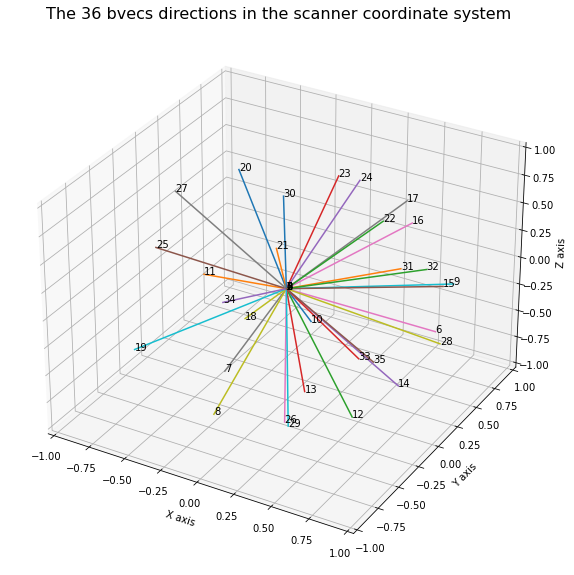

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
i = 0
for x, y, z in np.array(bvecs):
    X = [0,x]
    Y = [0,y]
    Z = [0,z]
    #ax.plot_wireframe([0, x], [0, y], [0, z])
    ax.plot(X,Y,Z)
    ax.text(x, y, z, '%d' % i)
    i = i+1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title(f'The {len(bvecs)} bvecs directions in the scanner coordinate system', size=16)
plt.show()

In [16]:
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

In [17]:
# Just a handy function to plot 
# (modified from https://github.com/mvdoc/grr_dti_tutorial/blob/master/dti_tutorial.ipynb)

def plot_axial(img, where=25, xs=8, ys=8, ax=None, mask=None, txt=None):
    if ax is None:
        plotter = plt
        plt.figure(figsize=(xs, ys))
        plt.title(txt, size=16)
    else:
        plotter = ax
    img_ = img.copy()
    if mask is not None:
        img_[np.logical_not(mask)] = 0.
    plotter.imshow(histeq(img_[:, :, where].T), origin='lower', cmap='gray', interpolation='nearest')

**First volume in the dwi dataset**

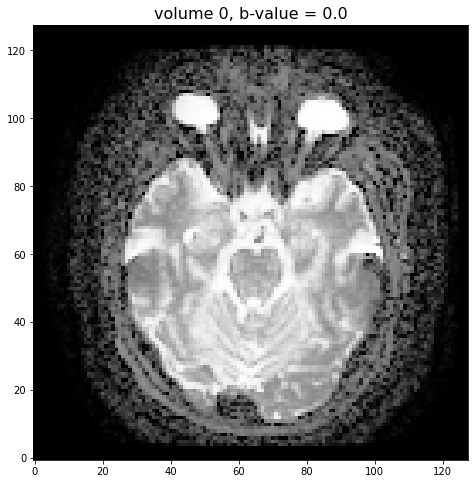

In [18]:
v = 0
txt = f'volume {v}, b-value = {bvals[v]}'
plot_axial(data[:, :, :, v], where=10, txt=txt )

## Reslicing

- Many of the methods for tractography require isotropic voxels
- Reslicing to isotropic voxels is possible and  easy in dipy, but it's better to have isotropic voxels out of the scanner,


In [19]:
print("Voxel size is {0}".format(img.header.get_zooms()[:3]))

Voxel size is (1.7188, 1.7188, 2.4)


In [20]:
from dipy.align.reslice import reslice

new_zooms = (2., 2., 2.)
data2, affine2 = reslice(data, affine, img.header.get_zooms()[:3], new_zooms)
print(data.shape, data2.shape)

(128, 128, 50, 36) (110, 110, 60, 36)


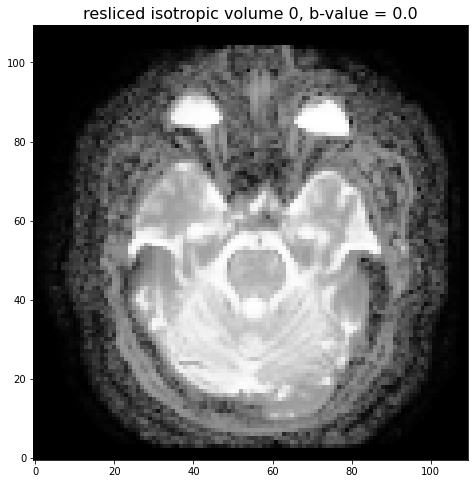

In [21]:
v = 0
txt = f'resliced isotropic volume {v}, b-value = {bvals[v]}'
plot_axial(data2[:, :, :, v], where=10, txt=txt )

### Skull stripping

- We can use many fancy methods (FSL's BET, AFNI's 3dSkullStrip, FreeSurfer, HD-BET, ...)
- Instead, we'll use a super quick way of separating an image from the background, the so-called [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method).
- We are going to perform skull-stripping on the image with $b = 0$, because it has better contrast

In [22]:
# Select the b0 data
data_b0 = data2[:, :, :, 0].squeeze()
# N.B. this values (2, 1, dilate=2) are completely ad-hoc. 
b0_mask, mask = median_otsu(data_b0, 2, 1, dilate=2)

And we get:

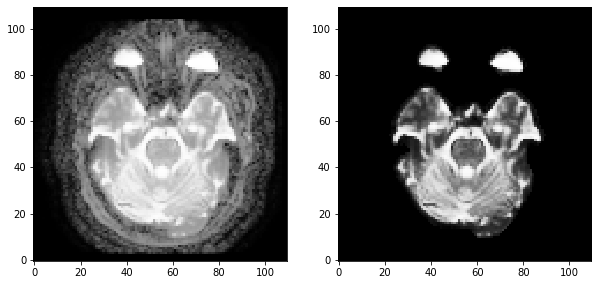

In [23]:
fig, axs = plt.subplots(1, 2, figsize=((10, 8)))
for i, ax in enumerate(axs.flatten()):
    mask_ = None if i == 0 else mask
    plot_axial(data_b0, ax=ax, mask=mask_, where=10)

### Motion correction and eddy distortions (skipped)

- At this point one should perform some sort of alignment to correct for motion
- One should also should correct for "eddy distortions", i.e. distortions caused by the rapid change in gradient

This example comes from FSL's wiki showing how eddy corrects distortions, see their page: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy

In [24]:
from IPython.display import Image, display, HTML
Image(url='https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy?action=AttachFile&do=get&target=before_after_hcp_v4.gif', width=600)

How about in this dataset?

(If you are on the Mac: get `convert` with `brew install ImageMagick` cf. https://brew.sh and https://imagemagick.org;<br>
`sudo apt install imagemagick` for Ubuntu)

In [25]:
%%time
# Save individual slices
import subprocess as sp
import os
from shutil import rmtree
if not os.path.exists('assets/dwi.gif'):
    try:
        os.makedirs('./img_out')
    except OSError:
        pass
    for i in range(1, data2.shape[-1]):
        fig, ax = plt.subplots(1, 1)
        plot_axial(data2[:, :, :, i], ax=ax, where=26)
        fig.savefig('img_out/dwi{0:02d}.png'.format(i))
        plt.close()
        
    _ = sp.check_call("convert img_out/dwi*.png -trim -delay 10 assets/dwi.gif".split())

if os.path.exists('./img_out'):
    rmtree('./img_out')

CPU times: user 165 µs, sys: 147 µs, total: 312 µs
Wall time: 271 µs


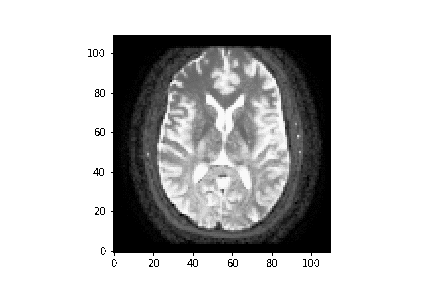

In [26]:
Image('./assets/dwi.gif', width=700)

We do see some distortions and some (not a lot of) movement during the scan. For a real analysis, you would make sure to perform some motion correction and re-alignment, as well as eddy correction.


- It's also possible to perform some denoising, but we are here going to skip that too. Read more about it on the dipy tutorial on denoising, e.g.  [Denoise images using Non-Local Means (NLMEANS)](https://dipy.org/documentation/1.4.0./examples_built/denoise_nlmeans/#example-denoise-nlmeans).

## Tractography

In the end, we want to estimate white-matter tracts, with some nice pictures. To get there, we need two things:
 1. Model the diffusion data per-voxel basis (think GLM), to get the most likely direction
 2. Find the tracts

- For step 1 we are going to use the Tensor Model, but there are many other models
- For step 2 we are going to use deterministic tractography

In [27]:
%%time
import dipy.reconst.dti as dti

# set up tensor model giving the bval/bvec information
tenmodel = dti.TensorModel(gtab)

# get masked data
data2_masked = data2.copy()
data2_masked[np.logical_not(mask)] = 0.

# fit tensor model to masked data
tenfit = tenmodel.fit(data2_masked)

CPU times: user 18.8 s, sys: 235 ms, total: 19 s
Wall time: 19 s


Now we can estimate the _Fractional Anisotropy_, an index of how directional each voxel is, i.e.

![tensor_fa](https://openi.nlm.nih.gov/imgs/512/1/3194768/PMC3194768_kjr-12-651-g001.png?keywords=condition)

Calculation of fractional anisotropy. Largest vector of diffusion ellipsoid is eigenvector 1 and its value is λ1. Shortest one is λ3 and remainder is λ2. Fractional anisotropy is calculated by each of eigenvalues. Fractional anisotropy varies from 0 (infinite isotropy) to 1 (infinite anisotropy).

(from: https://openi.nlm.nih.gov/imgs/512/1/3194768/PMC3194768_kjr-12-651-g001.png?keywords=condition)

In [28]:
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular
FA = fractional_anisotropy(tenfit.evals)
# set nans to 0 (e.g., when there is not enough signal)
FA[np.isnan(FA)] = 0

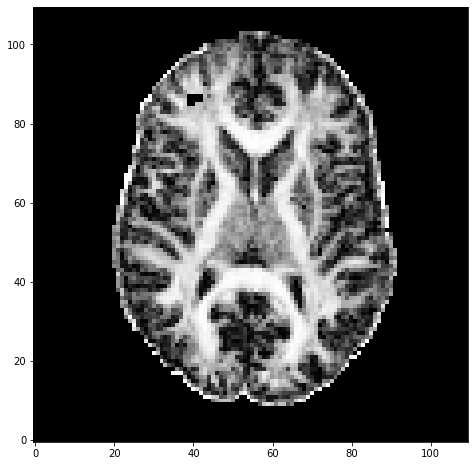

In [29]:
plot_axial(FA, where=26)

Somewhat more fancy:

(might need to `pip install fury` - in the `bmed360` environment)

```python
# Get RGB colors indicating the direction from the eigen vectors
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
# import dipy.viz.fvtk as fvtk
ren = fvtk.ren()
# zoom in into a nice area
evals = tenfit.evals[20:70, 10:50, 10:11]
evecs = tenfit.evecs[20:70, 10:50, 10:11]

cfa = RGB[20:70, 10:50, 10:11]
cfa /= cfa.max()

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
fvtk.record(ren, n_frames=1, out_path='assets/tensor_ellipsoids.png', size=(800, 800))
```

### The binary brain mask in DWI native space

dwi_brain_mask_data, dwi_brain_mask_affine, dwi_brain_mask_img 

In [30]:
print("Voxel size is {0}".format(dwi_brain_mask_img.header.get_zooms()[:3]))

Voxel size is (1.7188003, 1.7188008, 2.400001)


In [31]:
new_zooms = (2., 2., 2.)
mask2, maskaffine2 = reslice(dwi_brain_mask_data, dwi_brain_mask_affine, dwi_brain_mask_img.header.get_zooms()[:3], new_zooms)
print(dwi_brain_mask_data.shape, mask2.shape)

(128, 128, 50) (110, 110, 60)


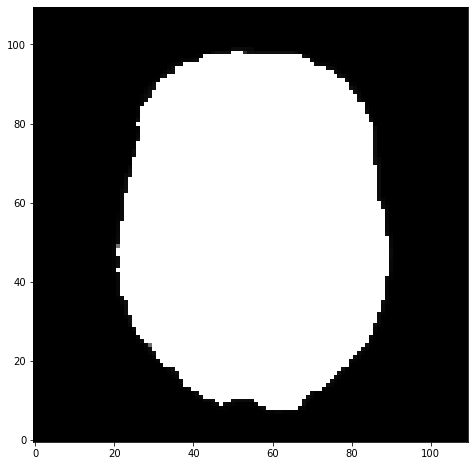

In [32]:
plot_axial(mask2, where=26)

###  Reconstructing Tracts   (WORK IN PROGRESS - not yet working for DiPy 1.4)

In [33]:
from dipy.tracking import utils
#from dipy.tracking.local import ThresholdTissueClassifier, LocalTracking
# from dipy.tracking.local_tracking import ThresholdTissueClassifier, LocalTracking
from dipy.segment import ThresholdTissueClassifier, LocalTracking
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
#from dipy.tracking.local import LocalTracking
#from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.io.trackvis import save_trk

ImportError: cannot import name 'ThresholdTissueClassifier' from 'dipy.segment' (/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/dipy/segment/__init__.py)

In [34]:
# find out peaks from our model
peaks = peaks_from_model(tenmodel, data2, default_sphere,
                 relative_peak_threshold=.8,
                 min_separation_angle=45,
                 mask=dwi_brain_mask_data, 
                 parallel=True, nbr_processes=4)

NameError: name 'peaks_from_model' is not defined

In [35]:
# first we need to set the seeds. we'll just have one seed for each voxel.
# if you increase that, you will get more tracts
seeds = utils.seeds_from_mask(white_matter_transformed, density=1, affine=dwi_affine2)

NameError: name 'white_matter_transformed' is not defined

In [36]:
# then we build a "tissue classifier" to know when to stop with our tracts white from gray matter
# it's very simple: whatever has an FA value greater than a threshold is considered white-matter
classifier = ThresholdTissueClassifier(FA, .25)

# next we build the streamlines
streamlines = LocalTracking(peaks, classifier, seeds, dwi_affine2, step_size=.5)

# streamlines is a generator, so we get a list to compute all of them
streamlines = list(streamlines)
# we select a random subset for visualization
plot_streamlines = select_random_set_of_streamlines(streamlines, 10000)

NameError: name 'ThresholdTissueClassifier' is not defined

In [37]:
# Prepare the display objects.
streamlines_actor = fvtk.line(plot_streamlines, line_colors(plot_streamlines))

# Create the 3d display.
r = fvtk.ren()
fvtk.add(r, streamlines_actor)

# Save still images for this static example. Or for interactivity use
fvtk.record(r, n_frames=1, out_path='img/deterministic.png',
            size=(800, 800))

NameError: name 'fvtk' is not defined

### Demo with TrackVis

In [38]:
#save_trk('img/deterministic.trk', streamlines, dwi_affine2, dwi_d2.shape[:3])

In [39]:
# save also the resampled brain so we can visualize it
#brain_resampled = nib.Nifti1Image(transformed, dwi_affine2)
#brain_resampled.to_filename('img/brain_resampled.nii.gz')

# END OF PART 1

In [40]:
#!dipy_horizon /Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/sub-102/ses-1/dwi/sub-102_ses-1_dwi.nii.gz

In [42]:
RGB = color_fa(FA, tenfit.evecs)

# Introduction to Basic Tracking (from the DiPy - [intro](https://dipy.org/documentation/1.4.0./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx))

Using our resliced $2 \times 2 \times 2$ isotropic data and mask.

Dipy uses affine matrices to represent the relationship between streamline
points, which are defined as points in a continuous 3d space, and image voxels,
which are typically arranged in a discrete 3d grid. Dipy uses a convention
similar to nifti files to interpret these affine matrices. This convention is
that the point at the center of voxel ``[i, j, k]`` is represented by the point
``[x, y, z]`` where ``[x, y, z, 1] = affine * [i, j, k, 1]``.  Also when the
phrase "voxel coordinates" is used, it is understood to be the same as ``affine = eye(4)``.

In [43]:
# Making AD HOC affine, denoted dummy2, without shear. Shear is not compatible with the tracking below

dummy2 = np.eye(4)*2
dummy2[3,3]=1.0
dummy2[:,3] = affine2[:,3]
dummy2

array([[  2.        ,   0.        ,   0.        , 113.63722992],
       [  0.        ,   2.        ,   0.        , -85.93726349],
       [  0.        ,   0.        ,   2.        ,  -9.88118267],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

The first thing we need to begin fiber tracking is a way of getting directions from this diffusion data set. In order to do that, we can fit the data to a Constant Solid Angle ODF Model. This model will estimate the Orientation Distribution Function (ODF) at each voxel. The ODF is the distribution of water diffusion as a function of direction. The peaks of an ODF are good estimates for the orientation of tract segments at a point in the image. Here, we use peaks_from_model to fit the data and calculated the fiber directions in all voxels of the white matter.

In [44]:
%%time

from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

response, ratio = auto_response_ssst(gtab, data2, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data2, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=mask2)

CPU times: user 18min 33s, sys: 19.8 s, total: 18min 53s
Wall time: 1min 12s


In [45]:
%%time
from dipy.viz import window, actor, has_fury

interactive = False

if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))

    window.record(scene, out_path='./assets/csa_direction_field.png', size=(900, 900))

    if interactive:
        window.show(scene, size=(800, 800))

CPU times: user 1.62 s, sys: 65.1 ms, total: 1.68 s
Wall time: 1.74 s


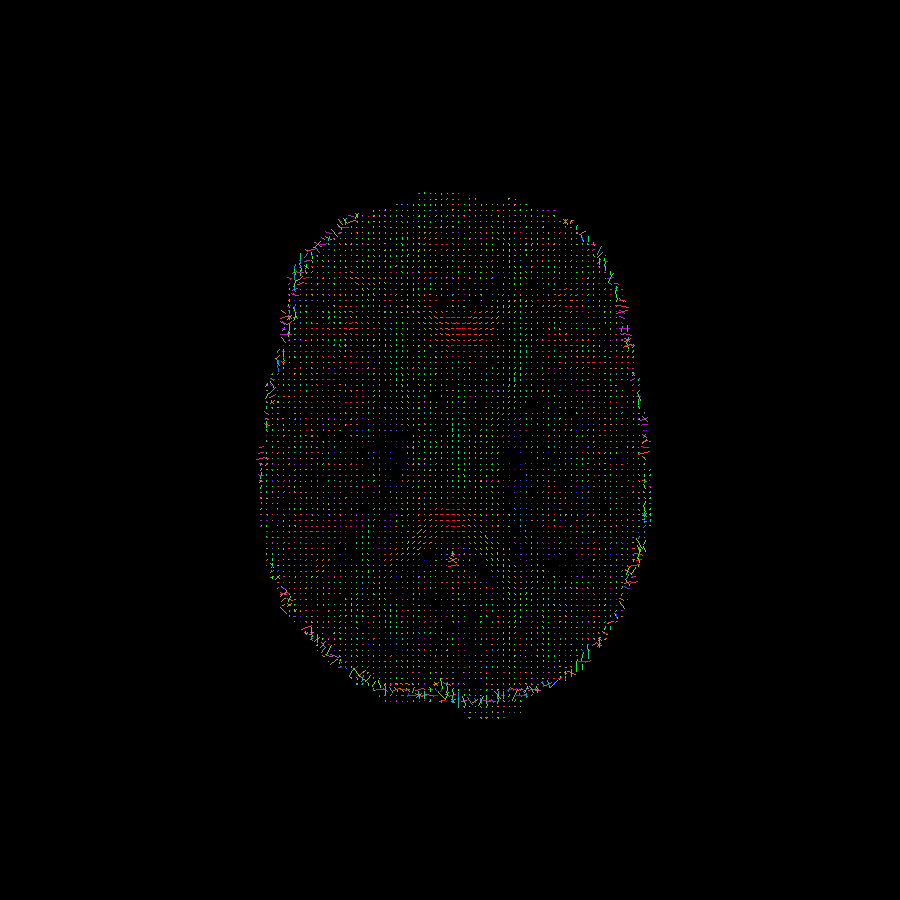

In [46]:
Image('./assets/csa_direction_field.png')

Next we need some way of restricting the fiber tracking to areas with good directionality information. We’ve already created the white matter mask, but we can go a step further and restrict fiber tracking to those areas where the ODF shows significant restricted diffusion by thresholding on the generalized fractional anisotropy (GFA).

In [47]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

For quality assurance we can also visualize a slice the GFA and the resulting tracking mask.

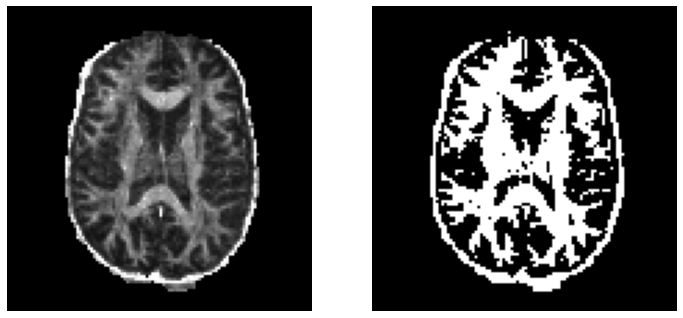

In [48]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2


plt.figure('GFA', figsize=(12, 10))
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('./assets/gfa_tracking_mask.png')
plt.show()

Before we can begin tracking is to specify where to “seed” (begin) the fiber tracking. Generally, the seeds chosen will depend on the pathways one is interested in modeling. Forthis example, we could use a 2 × 2 × 2 grid of seeds per voxel, in a sagittal slice of the corpus callosum. Tracking from such a region will give us a model of the corpus callosum tract. Such a slice could have a label value, say 2, in the labels image.

In [49]:
from dipy.tracking import utils

seeds = utils.seeds_from_mask(mask2, dummy2, density=[2, 2, 2])

Finally, we can bring it all together using LocalTracking, performing Using the EuDX algorithm [Garyfallidis12]. EuDX [Garyfallidis12] is a fast algorithm that we use here to generate streamlines. This algorithm is what is used here and the default option when providing the output of peaks directly in LocalTracking.

In [50]:
# affine2 has a shear - violating the LocalTracking algorithm, therfore we are using dummy2
print(affine2.shape)
affine2.round(2)

(4, 4)


array([[-2.0000e+00, -0.0000e+00,  0.0000e+00,  1.1364e+02],
       [-0.0000e+00,  2.0000e+00,  4.0000e-02, -8.5940e+01],
       [ 0.0000e+00, -4.0000e-02,  2.0000e+00, -9.8800e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [51]:
%%time

from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=dummy2, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

CPU times: user 4min 56s, sys: 2min 33s, total: 7min 29s
Wall time: 7min 28s


We will then display the resulting streamlines using the `fury` python package.

In [ ]:
from dipy.viz import colormap

interactive = False

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='./assets/tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(scene)

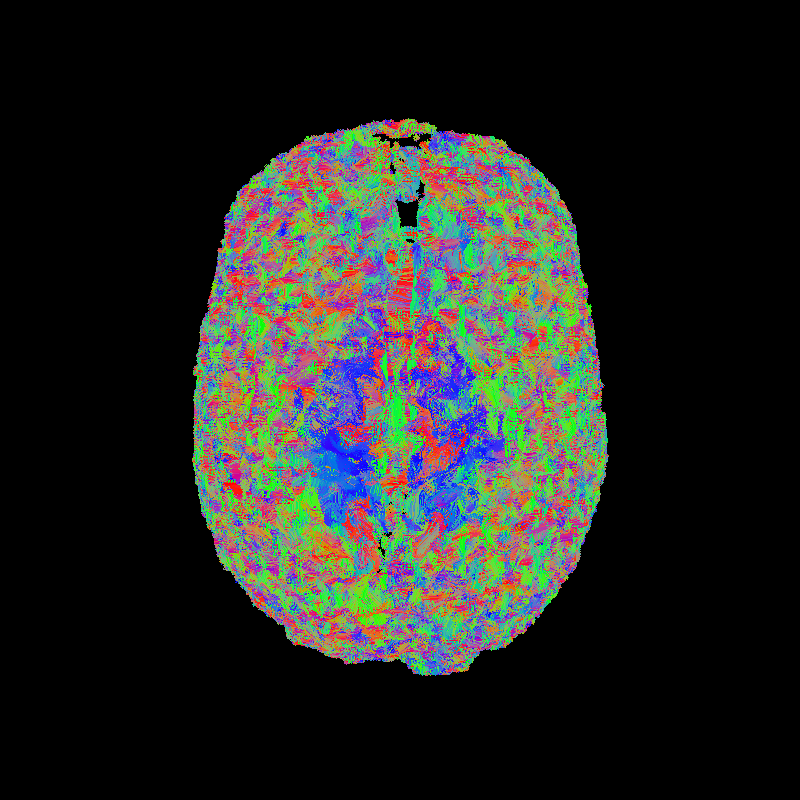

In [126]:
Image('./assets/tractogram_EuDX.png')

In [61]:
# Check: https://dipy.org/documentation/1.4.0./examples_built/streamline_formats/#example-streamline-formats

# If you wish to manually save Trk and Tck file using nibabel streamlines API for more freedom of action 
# (not recommended for beginners) you can create a valid header using create_tractogram_header

#nifti_header = create_nifti_header(affine, dimensions, voxel_sizes)
#nib.save(nib.Nifti1Image(np.zeros(dimensions), affine, nifti_header),'fake.nii.gz')
#nib.save(reference_anatomy, os.path.basename(ref_anat_filename))

#from dipy.io.streamline import load_trk
#sl, hdr = load_trk('/path/to/fname.trk')
#hdr['voxel_to_rasmm']


#from dipy.io.trackvis import save_trk
from dipy.io.streamline import save_trk 
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info, is_header_compatible)

#print(is_header_compatible(dummy2, bundles_filename[0]))
#save_trk(streamlines, '%s/deterministic.trk' % (dmri_res), bbox_valid_check=False) # , dummy2, data2.shape[:3])


nib.streamlines.save(streamlines, '%s/deterministic.trk' % (dmri_res))

The .npz file format is a zipped archive of files named after the variables they contain. The archive is not compressed and each file in the archive contains one variable in .npy format. For a description of the .npy format, see numpy.lib.format.

When opening the saved .npz file with load a NpzFile object is returned. This is a dictionary-like object which can be queried for its list of arrays (with the .files attribute), and for the arrays themselves.

When saving dictionaries, the dictionary keys become filenames inside the ZIP archive. Therefore, keys should be valid filenames. E.g., avoid keys that begin with / or contain ..

In [62]:
npzfile = np.load('%s/deterministic.trk.npz' % (dmri_res))

In [63]:
npzfile.files

['data', 'offsets', 'lengths']

In [66]:
npzfile['data'].shape

(93689939, 3)

In [72]:
x = nib.streamlines.detect_format('%s/deterministic.trk.npz' % (dmri_res))

In [82]:
my_trk = nib.streamlines.trk.TrkFile(streamlines, header=None)

In [85]:
my_trk.MAGIC_NUMBER

b'TRACK'

In [86]:
#save_trk(my_trk, '%s/deterministic_my.trk' % (dmri_res), bbox_valid_check=False)

# EXTRA

From https://github.com/dipy/dipy-dki-paper

In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [88]:
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki
import dipy.reconst.cross_validation as xval
import dipy.core.gradients as dpg
from dipy.segment.mask import median_otsu

In [89]:
import nibabel as nib

In [90]:
import tools
import imp
imp.reload(tools)
from tools import resample_volume

ModuleNotFoundError: No module named 'tools'

In [ ]:
# Replace with a loop over subjects:
subject = '991267'

In [ ]:
dwi_img = nib.load('/home/ubuntu/data/%s/sess/dwi/dwi.nii.gz'%subject)
gtab = dpg.gradient_table('/home/ubuntu/data/%s/sess/dwi/dwi.bvals'%subject, 
                          '/home/ubuntu/data/%s/sess/dwi/dwi.bvecs'%subject,
                          b0_threshold=10)

In [ ]:
data = dwi_img.get_data()

In [ ]:
label_img = nib.load('/home/ubuntu/data/%s/sess/anat/aparc+aseg.nii.gz'%subject)

resamp_label = resample_volume(label_img, dwi_img)

label_data = resamp_label.get_data()

# Cerebral white matter in both hemispheres + corpus callosum
wm_mask = (label_data==41) | (label_data==2) | (label_data==86)

In [ ]:

dki_model = dki.DiffusionKurtosisModel(gtab)
dti_model = dti.TensorModel(gtab)

In [ ]:

def calc_cod(model, data, mask=None, folds=5):
    pred = xval.kfold_xval(model, data, folds, mask=mask)
    cod = xval.coeff_of_determination(pred, data)
    return cod

In [ ]:
nib.save(nib.Nifti1Image(cod_dki, dwi_img.affine), 'COD_dki_%s.nii.gz'%subject)
nib.save(nib.Nifti1Image(cod_dki, dwi_img.affine), 'COD_dti_%s.nii.gz'%subject)

In [ ]:
plt.hist(cod_dti[np.isfinite(cod_dki)], bins=1000, histtype='step')
plt.hist(cod_dki[np.isfinite(cod_dki)], bins=1000, histtype='step')
plt.xlim([50,100])

In [ ]:
plt.hist(cod_dti[np.isfinite(cod_dki)] - cod_dki[np.isfinite(cod_dki)], bins=1000)
plt.xlim([-15, 15])

In [ ]:
lt.plot(cod_dti[np.isfinite(cod_dki)], cod_dki[np.isfinite(cod_dki)], '.', alpha=0.01)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel("COD (DTI)")
plt.ylabel("COD (DKI)")